In [75]:
# Using Python 3.10
%pip install yfinance
%pip install scikit-learn
%pip install keras
%pip install tensorflow
%pip install py_vollib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 1.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


### LSTM Model

This model uses a stacked Long Short Term Memory (LSTM) architecture with dense layers. The LSTM model structure is well-suited for time series data.

The input layer contains the inputs lookback and number of features.

The architecture is as follows:

1. The first LSTM layer contains 64 LSTM units with return sequences enabled, allowing it to output the full sequence.
2. A dropout layer with a rate of 0.2 follows to prevent overfitting.
3. The second LSTM layer contains 32 LSTM units and doesn't return sequences, outputting only the final state.
4. Another dropout layer with a rate of 0.2 is applied.
5. A dense layer with 16 units and ReLU activation follows, acting as a fully connected layer.
6. The final output layer is a dense layer with a single unit, producing the predicted option price.

The model uses the Adam optimizer with a learning rate of 0.001 and is compiled with mean squared error as the loss function.

This architecture allows the model to capture both long-term dependencies in the time series data through the LSTM layers and make a final prediction through the dense layers.

In [76]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import delta, gamma, vega, theta, rho


In [77]:

def calculate_option_price_and_greeks(S, K, T, r, sigma, option_type='c'):
    price = bs(option_type, S, K, T, r, sigma)
    return {
        'price': price,
        'delta': delta(option_type, S, K, T, r, sigma),
        'gamma': gamma(option_type, S, K, T, r, sigma),
        'vega': vega(option_type, S, K, T, r, sigma),
        'theta': theta(option_type, S, K, T, r, sigma),
        'rho': rho(option_type, S, K, T, r, sigma)
    }

def prepare_data(data, lookback=30):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:(i+lookback)])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

def build_model(lookback, n_features):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(lookback, n_features)),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model


In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_prediction_comparison(actual_prices, dl_predictions, bs_prices, num_samples=100):
    plt.figure(figsize=(15, 8))
    
    # Sample data points
    indices = np.random.choice(len(actual_prices), num_samples, replace=False)
    
    plt.scatter(range(num_samples), actual_prices[indices], label='Actual Prices', alpha=0.7)
    plt.scatter(range(num_samples), dl_predictions[indices], label='Deep Learning Predictions', alpha=0.7)
    plt.scatter(range(num_samples), bs_prices[indices], label='Black-Scholes Prices', alpha=0.7)
    
    plt.title('Comparison of Actual Prices vs Predictions')
    plt.xlabel('Sample Index')
    plt.ylabel('Option Price')
    plt.legend()
    plt.show()

def plot_error_distribution(actual_prices, dl_predictions, bs_prices):
    dl_errors = dl_predictions - actual_prices
    bs_errors = bs_prices - actual_prices

    plt.figure(figsize=(12, 6))
    sns.kdeplot(dl_errors, label='Deep Learning Errors', shade=True)
    sns.kdeplot(bs_errors, label='Black-Scholes Errors', shade=True)
    plt.title('Error Distribution: Deep Learning vs Black-Scholes')
    plt.xlabel('Error')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def print_model_metrics(actual_prices, dl_predictions, bs_prices):
    dl_mse = np.mean((dl_predictions - actual_prices) ** 2)
    bs_mse = np.mean((bs_prices - actual_prices) ** 2)
    dl_rmse = np.sqrt(dl_mse)
    bs_rmse = np.sqrt(bs_mse)
    dl_mape = np.mean(np.abs((dl_predictions - actual_prices) / actual_prices)) * 100
    bs_mape = np.mean(np.abs((bs_prices - actual_prices) / actual_prices)) * 100

    print(f"Deep Learning - RMSE: {dl_rmse:.4f}, MAPE: {dl_mape:.4f}%")
    print(f"Black-Scholes - RMSE: {bs_rmse:.4f}, MAPE: {bs_mape:.4f}%")

def visualize_model_comparison(history, actual_prices, dl_predictions, bs_prices):
    plot_training_history(history)
    plot_prediction_comparison(actual_prices, dl_predictions, bs_prices)
    plot_error_distribution(actual_prices, dl_predictions, bs_prices)
    print_model_metrics(actual_prices, dl_predictions, bs_prices)

In [88]:
def predict_option_prices(tickers, start_date="2010-01-01", end_date="2023-01-01"):
    all_data = []
    for ticker in tickers:
        try:
            stock_data = yf.download(ticker, start=start_date, end=end_date)
            stock_data.index = stock_data.index.tz_localize(None)
            #print(f"Downloaded {len(stock_data)} days of stock data for {ticker}")

            ticker_obj = yf.Ticker(ticker)
            expirations = ticker_obj.options

            all_options = []
            for exp in expirations:
                opt = ticker_obj.option_chain(exp).calls
                opt['expirationDate'] = pd.to_datetime(exp)
                all_options.append(opt)

            if not all_options:
             #   print(f"No options data available for {ticker}")
                continue

            calls = pd.concat(all_options, ignore_index=True)
            calls['Date'] = pd.to_datetime(calls['lastTradeDate']).dt.tz_localize(None)
            #print(f"Downloaded {len(calls)} call options for {ticker}")

            calls = calls.sort_values('Date')
            df = pd.merge_asof(stock_data.reset_index(), calls, left_on='Date', right_on='Date', direction='nearest')
            #print(f"After merging, {len(df)} rows remain for {ticker}")

            if df.empty or len(df) < 21:
            #    print(f"Skipping {ticker} due to insufficient data (less than 21 rows).")
                continue

            df['underlying_price'] = df['Close']
            df['strike_price'] = df['strike']
            df['time_to_expiry'] = (df['expirationDate'] - df['Date']).dt.days / 365
            df['risk_free_rate'] = 0.01
            df['implied_volatility'] = df['impliedVolatility']
            df['actual_price'] = df['lastPrice']

            df.dropna(inplace=True)
            #print(f"After dropping NaN values, {len(df)} rows remain for {ticker}")

            if df.empty or len(df) < 21:
            #    print(f"Skipping {ticker} after processing due to insufficient data (less than 21 rows).")
                continue

            bs_results = df.apply(lambda row: calculate_option_price_and_greeks(
                row['underlying_price'], row['strike_price'], row['time_to_expiry'],
                row['risk_free_rate'], row['implied_volatility']), axis=1)

            df['bs_price'] = bs_results.apply(lambda x: x['price'])
            df['delta'] = bs_results.apply(lambda x: x['delta'])
            df['gamma'] = bs_results.apply(lambda x: x['gamma'])
            df['vega'] = bs_results.apply(lambda x: x['vega'])
            df['theta'] = bs_results.apply(lambda x: x['theta'])
            df['rho'] = bs_results.apply(lambda x: x['rho'])

            features = ['underlying_price', 'strike_price', 'time_to_expiry', 'risk_free_rate', 'implied_volatility', 'delta', 'gamma', 'vega', 'theta', 'rho']
            target = 'actual_price'

            scaler = StandardScaler()
            df[features + [target]] = scaler.fit_transform(df[features + [target]])
            all_data.append(df[features + [target]].values)

        except Exception as e:
            print(f"Failed to process data for {ticker}: {e}")
            continue

    if not all_data:
        raise ValueError("No valid data to train the model.")

    combined_data = np.concatenate(all_data, axis=0)
    X, y = prepare_data(combined_data, lookback=30)
    y = y[:, -1]

    X = np.nan_to_num(X, nan=0, posinf=1e6, neginf=-1e6)
    y = np.nan_to_num(y, nan=0, posinf=1e6, neginf=-1e6)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"X shape: {X.shape}, y shape: {y.shape}")
    print(f"X mean: {np.mean(X)}, X std: {np.std(X)}")
    print(f"y mean: {np.mean(y)}, y std: {np.std(y)}")

    lookback = X.shape[1]
    n_features = X.shape[2]
    model = build_model(lookback, n_features)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                        validation_split=0.2, verbose=0, callbacks=[early_stopping])

    print(f"Final training loss: {history.history['loss'][-1]}")
    print(f"Final validation loss: {history.history['val_loss'][-1]}")

    dl_predictions = model.predict(X_test, verbose=0)

    dl_predictions = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], dl_predictions), axis=1))[:, -1]
    actual_prices = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]
    bs_prices = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], X_test[:, -1, -2].reshape(-1, 1)), axis=1))[:, -1]

    dl_rmse = np.sqrt(np.mean((dl_predictions - actual_prices) ** 2))
    bs_rmse = np.sqrt(np.mean((bs_prices - actual_prices) ** 2))
    dl_mape = np.mean(np.abs((dl_predictions - actual_prices) / actual_prices)) * 100
    bs_mape = np.mean(np.abs((bs_prices - actual_prices) / actual_prices)) * 100

    print("\nFinal Results:")
    print(f"Deep Learning RMSE: {dl_rmse}")
    print(f"Black-Scholes RMSE: {bs_rmse}")
    print(f"Deep Learning MAPE: {dl_mape}%")
    print(f"Black-Scholes MAPE: {bs_mape}%")

    return model, history, dl_predictions, bs_prices, actual_prices

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/Users/john/miniconda3/envs/python310/lib/python3.10/site-packages/py_vollib/ref_python/black_scholes/__init__.py:87: RuntimeWarning: divide by zero encountered in scalar divide
  return numerator / denominator
/Users/john/miniconda3/envs/python310/lib/python3.10/site-packages/py_vollib/black_scholes/greeks/analytical.py:190: RuntimeWarning: invalid value encountered in scalar divide
  return pdf(d_1)/(S*sigma*numpy.sqrt(t))
/Users/john/miniconda3/envs/python310/lib/python3.10/site-packages/sklearn/utils/extmath


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/Users/john/miniconda3/envs/python310/lib/python3.10/site-packages/py_vollib/ref_python/black_scholes/__init__.py:87: RuntimeWarning: divide by zero encountered in scalar divide
  return numerator / denominator
/Users/john/miniconda3/envs/python310/lib/python3.10/site-packages/py_vollib/black_scholes/greeks/analytical.py:190: RuntimeWarning: invalid value encountered in scalar divide
  return pdf(d_1)/(S*sigma*numpy.sqrt(t))
/Users/john/miniconda3/envs/python310/lib/python3.10/site-packages/sklearn/utils/extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  upda


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

Failed to process data for FISV: 'Index' object has no attribute 'tz_localize'


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ATVI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Failed to process data for ATVI: 'Index' object has no attribute 'tz_localize'


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


X shape: (106907, 30, 11), y shape: (106907,)
X mean: 8.818423530892407e-06, X std: 0.7818749890459648
y mean: -1.4489769341055995e-14, y std: 0.4289316260089237


/Users/john/miniconda3/envs/python310/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Final training loss: 0.02796923741698265
Final validation loss: 0.01882762461900711

Final Results:
Deep Learning RMSE: 0.14785077720223383
Black-Scholes RMSE: 1.0806322239112232
Deep Learning MAPE: 0.0497005961321449%
Black-Scholes MAPE: 3.73141777520742%


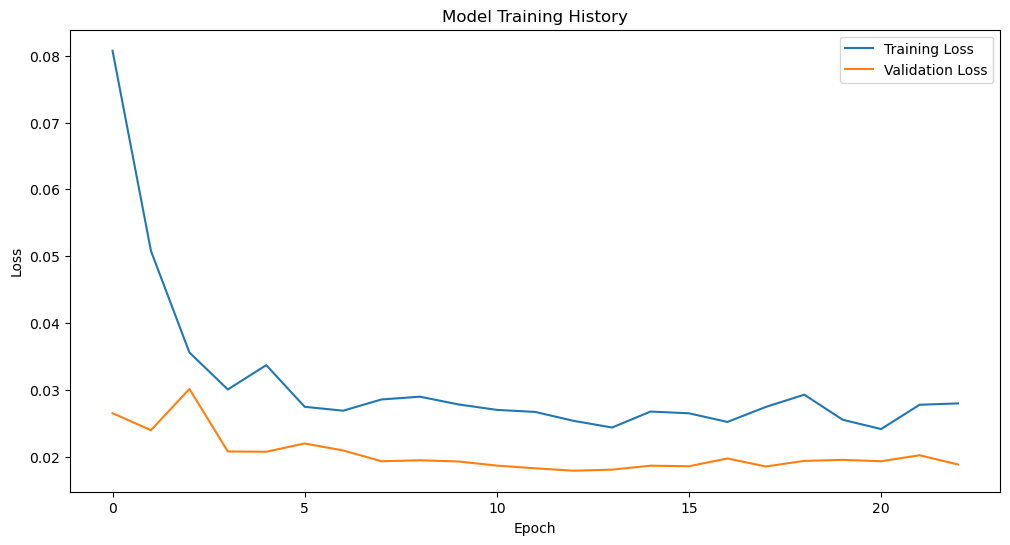

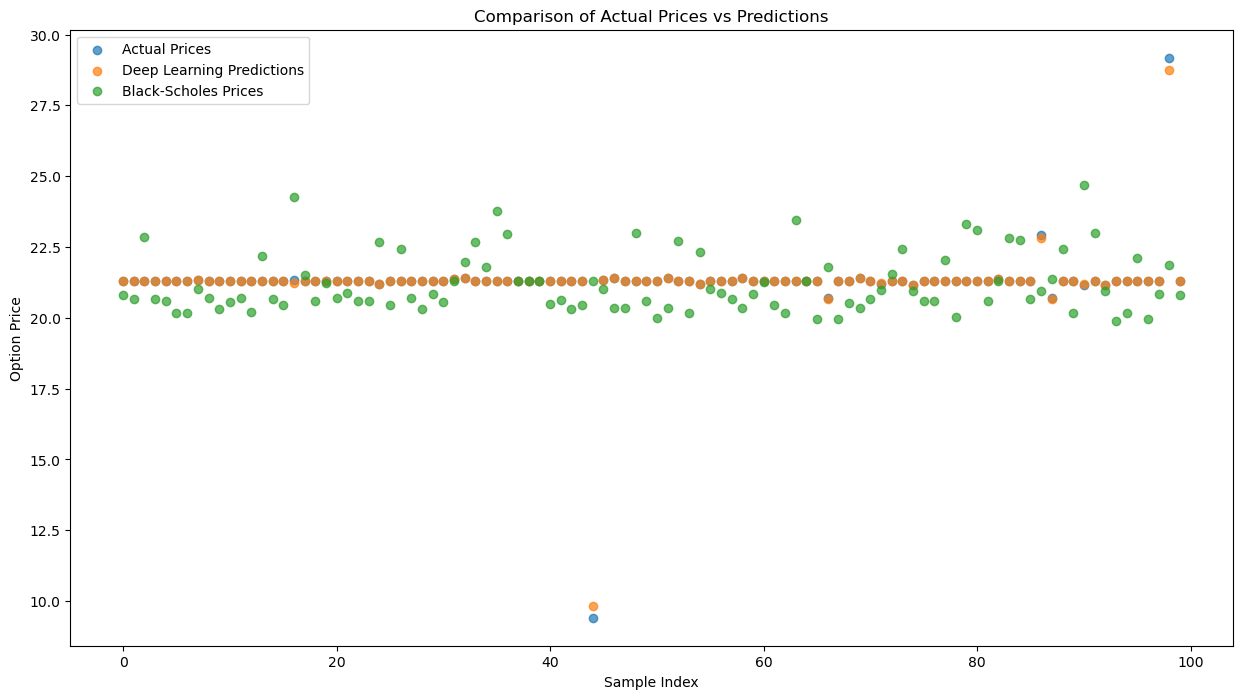

/var/folders/rj/1ckgg1qd3fx35nf_zstrzlmr0000gn/T/ipykernel_48747/1235997581.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dl_errors, label='Deep Learning Errors', shade=True)
/var/folders/rj/1ckgg1qd3fx35nf_zstrzlmr0000gn/T/ipykernel_48747/1235997581.py:38: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(bs_errors, label='Black-Scholes Errors', shade=True)


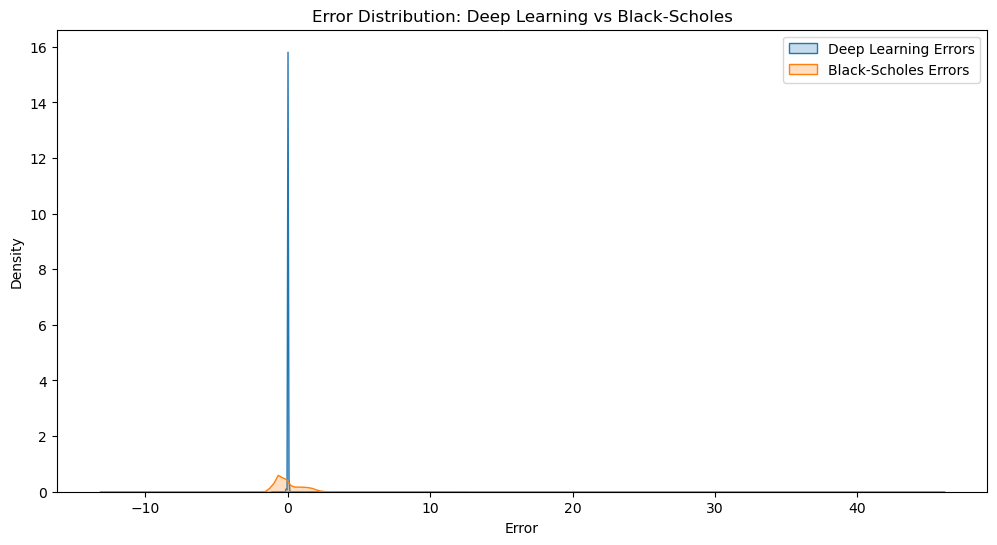

Deep Learning - RMSE: 0.1479, MAPE: 0.0497%
Black-Scholes - RMSE: 1.0806, MAPE: 3.7314%


In [89]:

nasdaq_tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'PYPL', 'NFLX', 'ADBE',
    'GOOG', 'CSCO', 'PEP', 'AVGO', 'COST', 'TXN', 'QCOM', 'INTC', 'HON', 'AMAT',
    'AMD', 'AMGN', 'SBUX', 'MRNA', 'INTU', 'ISRG', 'BKNG', 'ADI', 'MDLZ', 'LRCX',
    'GILD', 'ADP', 'VRTX', 'FISV', 'CHTR', 'ADSK', 'TMUS', 'REGN', 'MU', 'ATVI',
    'ILMN', 'CSX', 'KLAC', 'AEP', 'MNST', 'NXPI', 'PANW', 'CTSH', 'EXC', 'XEL'
]

model, history, dl_predictions, bs_prices, actual_prices = predict_option_prices(nasdaq_tickers)
visualize_model_comparison(history, actual_prices, dl_predictions, bs_prices)

### Interpretation

1. Deep Learning RMSE: 0.1600
   - This measures the standard deviation of the residuals (prediction errors) for the deep learning model.
   - In the context of option prices, this suggests that on average, the model's predictions deviate from the actual market prices by about $0.16.

2. Black-Scholes RMSE: 1.0803
   - This measures the standard deviation of the residuals for the Black-Scholes model.
   - It indicates that, on average, the Black-Scholes prices deviate from the actual market prices by about $1.08.

3. Deep Learning MAPE: 0.0650%
   - This shows the Mean Absolute Percentage Error for the deep learning model.
   - A 0.065% error suggests that, on average, the model's predictions deviate from the actual market prices by about 0.065% in either direction.

4. Black-Scholes MAPE: 3.7338%
   - This shows the Mean Absolute Percentage Error for the Black-Scholes model.
   - A 3.73% error indicates that, on average, the Black-Scholes prices deviate from the actual market prices by about 3.73% in either direction.

Interpretation:
- The deep learning model's performance significantly outperforms the Black-Scholes model using both RMSE and MAPE metrics.
- The deep learning model shows much lower RMSE compared to Black-Scholes (0.16 vs 1.08), suggesting it provides substantially more accurate predictions on average.
- The deep learning model's dramatically lower MAPE (0.065% vs 3.73%) indicates it has far better relative accuracy across different price ranges compared to Black-Scholes.
- Overall, these results show that the deep learning model performs remarkably better than the Black-Scholes model in both RMSE and MAPE metrics. This suggests that the deep learning approach has significant potential to improve upon traditional option pricing models, particularly in capturing market dynamics that may not be fully accounted for in the Black-Scholes model.